In [1]:
import os
import pandas as pd
import janitor
import numpy as np

pd.set_option("display.max_columns", 100)

from utils.utils import fit_exp, save_mpl_fig
from utils.data_utils import pandas_to_tex
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context="notebook", font_scale=1.05, style="whitegrid", palette="dark"
)  #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from scipy import stats
from scipy.stats import kstest

DATAPATH = "../data/individual_browsing_data.csv"
FIGSAVEDIR = "../figs"

df_ind = (
    pd.read_csv(DATAPATH)
    # Normalize seconds to hours
    .assign(
        **{
            k: lambda df_, col=k: df_[col] / 3600
            for k in ["duration", "duration_adult", "duration_nonadult"]
        }
    )
)
df_ind

,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.000000,0.0,0.000000,21.567222,21.567222,0.000000,0.0,1,1960,60,3600,4
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,72.263333,9.975860,1.0,5,1990,31,961,4
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.000000,1.0,0.000000,0.328333,0.328333,0.000000,0.0,1,1960,64,4096,4
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,8.339167,20.538956,1.0,2,1970,57,3249,3
4,201590505,1977,1,4,5,3,3,1,6,4,D,0.0,11086.0,11086.0,0.000000,0.0,0.000000,106.433611,106.433611,0.000000,0.0,4,1980,46,2116,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1802885,1935,1,1,6,4,5,2,12,3,R,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1,1940,88,7744,4
1196,1809723,1943,1,1,2,1,1,1,51,3,D,0.0,9805.0,9805.0,0.000000,0.0,0.000000,353.503611,353.503611,0.000000,0.0,1,1940,80,6400,2
1197,1827351,1947,1,1,5,3,4,1,31,2,I,0.0,543.0,543.0,0.000000,NaN,0.000000,6.646944,6.646944,0.000000,0.0,1,1950,76,5776,4
1198,1924249,1980,1,7,4,2,7,2,6,4,R,182.0,21379.0,21561.0,0.844117,1.0,0.581667,86.076667,86.658333,0.671218,1.0,5,1980,43,1849,4


### Distribution of visit duration on adult sites

In [2]:
outcome_var = "duration_adult"

In [3]:
# (fold cell) Prep data
qcut_opts = {
    "q": 10,
    "precision": 1,
    "labels": range(10, 101, 10),
    "duplicates": "drop",
}

_df = df_ind.query(f"{outcome_var}>0").assign(
    **{f"decile_{outcome_var}": lambda df: pd.qcut(df[outcome_var], **qcut_opts)}
)
print(f"N = {len(_df)}")
_df.head(3)

N = 353


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,decile_duration_adult
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,72.263333,9.975860,1.0,5,1990,31,961,4,90
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,8.339167,20.538956,1.0,2,1970,57,3249,3,70
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,8.751667,114.302778,123.054444,7.112028,1.0,3,2000,27,729,4,90


/tmp/ipykernel_27505/254150336.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


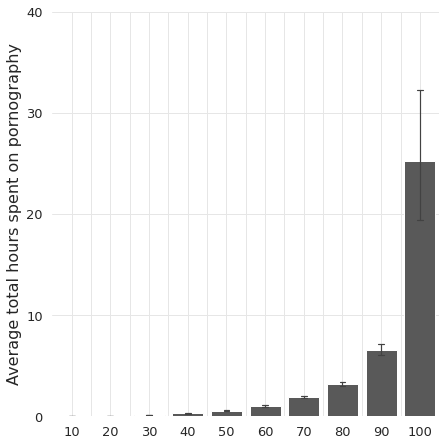

In [4]:
# (fold cell) Plot deciles
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

sns.barplot(
    x=f"decile_{outcome_var}",
    y=outcome_var,
    data=_df,
    color=".35",
    ci=95,
    errwidth=1.2,
    capsize=0.15,
)
ax.set_yticks(range(0, 50, 10))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.set_xlabel("")
ax.set_ylabel("Average total hours spent on pornography", size=16)
ax.tick_params(axis="both", which="major", labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_duration_on_adultsites"))

In [5]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
tab_deciles = (
    _df[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .assign(**{outcome_var: lambda df: df[outcome_var].round(1)})
)
pandas_to_tex(tab_deciles, "../tabs/percentiles_duration_adultsites_by_individuals")
tab_deciles

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,duration_adult
0,0.00,0.0
1,0.10,0.0
2,0.20,0.1
3,0.30,0.2
4,0.40,0.4
5,0.50,0.7
6,0.60,1.5
7,0.70,2.4
8,0.80,4.5
9,0.90,10.1


### Distribution of visit duration on adult sites, by partisanship

In [6]:
# (fold cell) Get deciles mean and CI (from SEM)
df_decile_agg = (
    df_ind
    # Make deciles by party
    .query(f"{outcome_var}>0")
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: (
                df.groupby("party")[outcome_var].transform(
                    lambda x: pd.qcut(x, **qcut_opts)
                )
            )
        },
    )
    .groupby(["party", f"decile_{outcome_var}"])[outcome_var]
    .agg(["mean", "sem"])
    .reset_index()
    # Get CI from SEM
    .assign(
        ll=lambda df: df["mean"] - 1.96 * df["sem"],
        hl=lambda df: df["mean"] + 1.96 * df["sem"],
        ci=lambda df: df["hl"] - df["ll"],
    )
    #     Manually "dodge" the points to plot, by party
    .assign(
        **{f"decile_{outcome_var}": lambda df: df[f"decile_{outcome_var}"].astype(int)}
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "D",
                df[f"decile_{outcome_var}"] - 4,
                df[f"decile_{outcome_var}"],
            )
        }
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "R",
                df[f"decile_{outcome_var}"] - 6,
                df[f"decile_{outcome_var}"],
            )
        }
    )
)
df_decile_agg.head(4)

,party,decile_duration_adult,mean,sem,ll,hl,ci
0,D,6,0.010694,0.001717,0.007328,0.014061,0.006732
1,D,16,0.038759,0.002833,0.033207,0.044312,0.011105
2,D,26,0.078741,0.004063,0.070778,0.086703,0.015925
3,D,36,0.156701,0.007611,0.141785,0.171618,0.029833


In [7]:
# Prep data for scatter
df_duration = (
    df_ind.dropna(subset="party").query(f"{outcome_var}>0")
    # Retrieve quantiles of visits to adult sites
    .case_when(
        # when R, D, or I
        lambda df: df.party == "R",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='R'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "D",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='D'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "I",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='I'")[outcome_var].sort_values(), x
            )
        ),
        # else nan
        np.nan,
        column_name=f"quantiles_{outcome_var}",
    )
)
df_duration.head(3)

/home/lsys/miniconda3/lib/python3.10/site-packages/pandas_flavor/register.py:153: DeprecationWarning: The last argument in the variable arguments has been assigned as the default. Note however that this will be deprecated in a future release; use an even number of boolean conditions and values, and pass the default argument to the `default` parameter instead.
  return method(self._obj, *args, **kwargs)


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,quantiles_duration_adult
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,8.751667,114.302778,123.054444,7.112028,1.0,3,2000,27,729,4,83.582090
19,203457165,1960,2,1,3,1,1,1,41,4,D,21.0,28364.0,28385.0,0.073983,0.0,0.087778,191.528056,191.615833,0.045809,1.0,1,1960,63,3969,3,27.272727
20,204288513,1991,1,1,2,3,4,2,54,3,I,36.0,79886.0,79922.0,0.045044,NaN,0.088889,219.477500,219.566389,0.040484,1.0,1,1990,32,1024,2,14.925373


In [8]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}

running_var = f"quantiles_{outcome_var}"

scatter_opts = {
    "x": running_var,
    "y": outcome_var,
    "marker": "x",
    "s": 15,
    "linewidths": 0.5,
    "alpha": 0.4,
}

errorbar_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "yerr": "ci",
    "elinewidth": 2.5,
    "ls": "none",
    "alpha": 0.6,
    "zorder": 1,
}
scatter_decile_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "marker": "o",
    "s": 60,
    "alpha": 0.85,
}
line_opts = {
    "lw": 1.5,
    "alpha": 0.5,
}

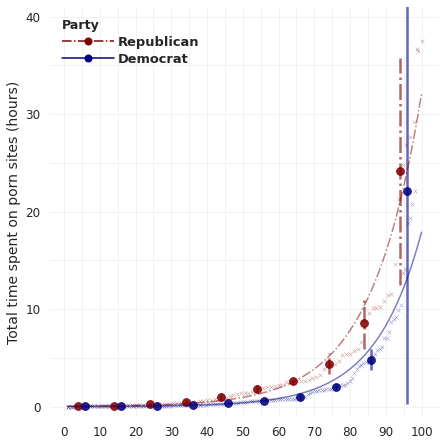

In [9]:
# (fold cell) Plot splits by party
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_duration.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_opts,
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts,
    )

# Connect deciles
for party in ["R", "D"]:
    y = df_duration.query(f"party=='{party}'")[outcome_var]
    x = df_duration.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x, y)
    plt.plot(
        x_fitted,
        y_fitted,
        color=palette[party],
        linestyle=errorlinestyle[party],
        **line_opts,
    )

# Figure settings
ax.set_xticks(range(0, 110, 10))
ax.set_xlabel("")
ax.set_ylabel("Total time spent on porn sites (hours)", size=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_yticks(range(0, 50, 10))
ax.set_ylim(-1, 41)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D(
    [], [], color="maroon", marker="o", ls="-.", markersize=7, label="Republican"
)
dem_hand = mlines.Line2D(
    [],
    [],
    color="navy",
    marker="o",
    ls="-",
    markersize=7,
    label="Democrat",
)
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand],
    handlelength=4,
    handletextpad=0.3,
    labelspacing=0.3,
    title="Party",
    frameon=False,
    prop={"weight": "bold", "size": 13},
    #     title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True, bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_duration_on_adultsites_by_party"))

In [10]:
# (fold cell) Get table of percentiles
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
_tab_R = (
    _df.query("party=='R'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_R")
)
_tab_D = (
    _df.query("party=='D'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_D")
)

tab_perc = _tab_R.merge(_tab_D, on="Percentile", how="left", validate="1:1").assign(
    **{f"{outcome_var}_R": lambda df: df[f"{outcome_var}_R"].map("{:,.1f}".format)},
    **{f"{outcome_var}_D": lambda df: df[f"{outcome_var}_D"].map("{:,.1f}".format)},
)
pandas_to_tex(
    tab_perc, "../tabs/percentiles_duration_adultsites_by_individuals_by_party"
)
tab_perc

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,duration_adult_R,duration_adult_D
0,0.00,0.0,0.0
1,0.10,0.1,0.0
2,0.20,0.2,0.1
3,0.30,0.3,0.1
4,0.40,0.7,0.2
5,0.50,1.4,0.5
6,0.60,2.2,0.7
7,0.70,3.0,1.5
8,0.80,5.5,2.7
9,0.90,11.2,7.0


In [11]:
# Hours
x = _df.query("party=='R'")[outcome_var]
y = _df.query("party=='D'")[outcome_var]
stat, p_value = kstest(x, y)
print(f"KS stat={stat:.4f}, p-val={p_value:.4f}")

KS stat=0.2227, p-val=0.0048


In [12]:
# (fold cell) Get table of percentiles (untruncated by positive consumption)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
_tab_R = (
    df_ind.query("party=='R'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_R")
)
_tab_D = (
    df_ind.query("party=='D'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_D")
)

tab_perc = _tab_R.merge(_tab_D, on="Percentile", how="left", validate="1:1").assign(
    **{f"{outcome_var}_R": lambda df: df[f"{outcome_var}_R"].map("{:,.1f}".format)},
    **{f"{outcome_var}_D": lambda df: df[f"{outcome_var}_D"].map("{:,.1f}".format)},
)
pandas_to_tex(
    tab_perc,
    "../tabs/percentiles_duration_adultsites_by_individuals_by_party_untruncated",
)
tab_perc

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,duration_adult_R,duration_adult_D
0,0.00,0.0,0.0
1,0.10,0.0,0.0
2,0.20,0.0,0.0
3,0.30,0.0,0.0
4,0.40,0.0,0.0
5,0.50,0.0,0.0
6,0.60,0.0,0.0
7,0.70,0.0,0.0
8,0.80,0.3,0.2
9,0.90,2.6,1.0


In [13]:
# Hours (untruncated)
x = df_ind.query("party=='R'")[outcome_var]
y = df_ind.query("party=='D'")[outcome_var]
stat, p_value = kstest(x, y)
print(f"KS stat={stat:.4f}, p-val={p_value:.4f}")

KS stat=0.0616, p-val=0.3742


### Distribution of proportion of visit duration on adult sites

In [14]:
outcome_var = "prop_adult_duration"

In [15]:
# (fold cell) Prep data
qcut_opts = {
    "q": 10,
    "precision": 1,
    "labels": range(10, 101, 10),
    "duplicates": "drop",
}

_df = df_ind.query(f"{outcome_var}>0").assign(
    **{f"decile_{outcome_var}": lambda df: pd.qcut(df[outcome_var], **qcut_opts)}
)
print(f"N = {len(_df)}")
_df.head(3)

N = 353


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,decile_prop_adult_duration
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.735190,NaN,7.208889,65.054444,72.263333,9.975860,1.0,5,1990,31,961,4,80
3,201302005,1966,2,2,3,5,8,1,12,3,NaN,20.0,527.0,547.0,3.656307,NaN,1.712778,6.626389,8.339167,20.538956,1.0,2,1970,57,3249,3,90
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,8.751667,114.302778,123.054444,7.112028,1.0,3,2000,27,729,4,70


/tmp/ipykernel_27505/2637190499.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(


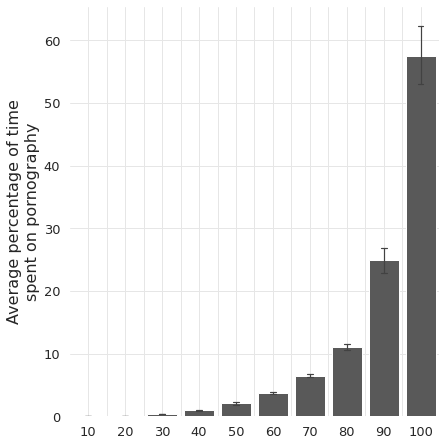

In [16]:
# (fold cell) Plot deciles
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

sns.barplot(
    x=f"decile_{outcome_var}",
    y=outcome_var,
    data=_df,
    color=".35",
    ci=95,
    errwidth=1.2,
    capsize=0.15,
)
ax.set_yticks(range(0, 70, 10))
ax.set_xlabel("")
ax.set_ylabel("Average percentage of time\nspent on pornography", size=16)
ax.tick_params(axis="both", which="major", labelsize=13)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_proportion_duration_on_adultsites"))

In [17]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
tab_deciles = (
    _df[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .assign(**{outcome_var: lambda df: df[outcome_var].round(1)})
)
pandas_to_tex(
    tab_deciles, "../tabs/percentiles_proportion_duration_adultsites_by_individuals"
)
tab_deciles

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,prop_adult_duration
0,0.00,0.0
1,0.10,0.0
2,0.20,0.1
3,0.30,0.7
4,0.40,1.3
5,0.50,3.1
6,0.60,4.8
7,0.70,8.4
8,0.80,14.3
9,0.90,36.4


### Distribution of proportion of visits to adult sites, by partisanship

In [18]:
# (fold cell) Get deciles mean and CI (from SEM)
df_decile_agg = (
    df_ind
    # Make deciles by party
    .query(f"{outcome_var}>0")
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: (
                df.groupby("party")[outcome_var].transform(
                    lambda x: pd.qcut(x, **qcut_opts)
                )
            )
        },
    )
    .groupby(["party", f"decile_{outcome_var}"])[outcome_var]
    .agg(["mean", "sem"])
    .reset_index()
    # Get CI from SEM
    .assign(
        ll=lambda df: df["mean"] - 1.96 * df["sem"],
        hl=lambda df: df["mean"] + 1.96 * df["sem"],
        ci=lambda df: df["hl"] - df["ll"],
    )
    # Manually "dodge" the points to plot, by party
    .assign(
        **{f"decile_{outcome_var}": lambda df: df[f"decile_{outcome_var}"].astype(int)}
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "D",
                df[f"decile_{outcome_var}"] - 4,
                df[f"decile_{outcome_var}"],
            )
        }
    )
    .assign(
        **{
            f"decile_{outcome_var}": lambda df: np.where(
                df.party == "R",
                df[f"decile_{outcome_var}"] - 6,
                df[f"decile_{outcome_var}"],
            )
        }
    )
)
df_decile_agg.head(4)

,party,decile_prop_adult_duration,mean,sem,ll,hl,ci
0,D,6,0.013870,0.002243,0.009474,0.018266,0.008793
1,D,16,0.045638,0.002789,0.040172,0.051105,0.010933
2,D,26,0.158039,0.017484,0.123771,0.192307,0.068536
3,D,36,0.635574,0.049800,0.537965,0.733182,0.195217


In [19]:
# Prep data for scatter
df_duration = (
    df_ind.dropna(subset="party").query(f"{outcome_var}>0")
    # Retrieve quantiles of visits to adult sites
    .case_when(
        # when R, D, or I
        lambda df: df.party == "R",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='R'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "D",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='D'")[outcome_var].sort_values(), x
            )
        ),
        lambda df: df.party == "I",
        lambda df: df[outcome_var].apply(
            lambda x: stats.percentileofscore(
                df.query("party=='I'")[outcome_var].sort_values(), x
            )
        ),
        # else nan
        np.nan,
        column_name=f"quantiles_{outcome_var}",
    )
)
df_duration.head(3)

/home/lsys/miniconda3/lib/python3.10/site-packages/pandas_flavor/register.py:153: DeprecationWarning: The last argument in the variable arguments has been assigned as the default. Note however that this will be deprecated in a future release; use an even number of boolean conditions and values, and pass the default argument to the `default` parameter instead.
  return method(self._obj, *args, **kwargs)


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,quantiles_prop_adult_duration
5,201631749,1996,1,3,5,3,4,1,6,4,I,1107.0,16361.0,17468.0,6.337302,NaN,8.751667,114.302778,123.054444,7.112028,1.0,3,2000,27,729,4,64.179104
19,203457165,1960,2,1,3,1,1,1,41,4,D,21.0,28364.0,28385.0,0.073983,0.0,0.087778,191.528056,191.615833,0.045809,1.0,1,1960,63,3969,3,16.233766
20,204288513,1991,1,1,2,3,4,2,54,3,I,36.0,79886.0,79922.0,0.045044,NaN,0.088889,219.477500,219.566389,0.040484,1.0,1,1990,32,1024,2,8.955224


In [20]:
# (fold cell) Standard Options
palette = {"R": "Maroon", "D": "Navy"}
errorlinestyle = {"R": "-.", "D": "-"}

running_var = f"quantiles_{outcome_var}"

scatter_opts = {
    "x": running_var,
    "y": outcome_var,
    "marker": "x",
    "s": 15,
    "linewidths": 0.5,
    "alpha": 0.4,
}

errorbar_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "yerr": "ci",
    "elinewidth": 2.5,
    "ls": "none",
    "alpha": 0.6,
    "zorder": 1,
}
scatter_decile_opts = {
    "x": f"decile_{outcome_var}",
    "y": "mean",
    "marker": "o",
    "s": 60,
    "alpha": 0.85,
}
line_opts = {
    "lw": 1.5,
    "alpha": 0.5,
}

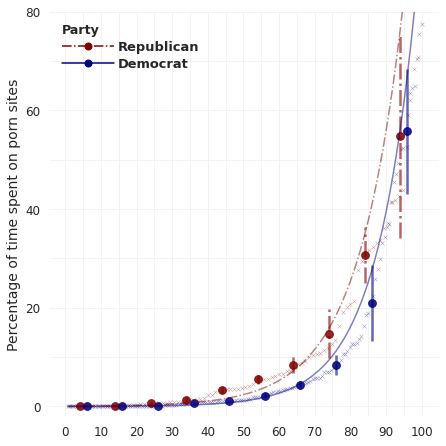

In [21]:
# (fold cell) Plot splits by party
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

# Scatterpoints for individuals
for party in ["R", "D"]:
    plt.scatter(
        data=df_duration.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_opts,
    )
# Error bars
for party in ["R", "D"]:
    eb = plt.errorbar(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **errorbar_opts,
    )
    if party == "R":
        eb[-1][0].set_linestyle(errorlinestyle["R"])

# Scatter for the 2 parties x 10 deciles
for party in ["R", "D"]:
    plt.scatter(
        data=df_decile_agg.query(f"party=='{party}'"),
        color=palette[party],
        **scatter_decile_opts,
    )

# Connect deciles
for party in ["R", "D"]:
    y = df_duration.query(f"party=='{party}'")[outcome_var]
    x = df_duration.query(f"party=='{party}'")[running_var]
    x_fitted, y_fitted = fit_exp(x, y)
    plt.plot(
        x_fitted,
        y_fitted,
        color=palette[party],
        linestyle=errorlinestyle[party],
        **line_opts,
    )

# Figure settings
ax.set_xticks(range(0, 110, 10))
ax.set_xlabel("")
ax.set_ylabel("Percentage of time spent on porn sites", size=14)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_yticks(range(0, 90, 20))
ax.set_ylim(-2, 80)

# Grids
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.get_yaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".95")
ax.yaxis.grid(True, which="both", color=".95")

# Custom Legend
rep_hand = mlines.Line2D(
    [], [], color="maroon", marker="o", ls="-.", markersize=7, label="Republican"
)
dem_hand = mlines.Line2D(
    [],
    [],
    color="navy",
    marker="o",
    ls="-",
    markersize=7,
    label="Democrat",
)
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand],
    handlelength=4,
    handletextpad=0.3,
    labelspacing=0.3,
    title="Party",
    frameon=False,
    prop={"weight": "bold", "size": 13},
    #     title_fontproperties={'weight':'bold', 'size':14},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True, bottom=True)
plt.tight_layout()
save_mpl_fig(
    os.path.join(FIGSAVEDIR, "distribution_proportion_duration_on_adultsites_by_party")
)

In [22]:
# (fold cell) Get table of percentiles
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
_tab_R = (
    _df.query("party=='R'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_R")
)
_tab_D = (
    _df.query("party=='D'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_D")
)

tab_perc = _tab_R.merge(_tab_D, on="Percentile", how="left", validate="1:1").assign(
    **{f"{outcome_var}_R": lambda df: df[f"{outcome_var}_R"].map("{:,.1f}".format)},
    **{f"{outcome_var}_D": lambda df: df[f"{outcome_var}_D"].map("{:,.1f}".format)},
)
pandas_to_tex(
    tab_perc,
    "../tabs/percentiles_proportion_duration_adultsites_by_individuals_by_party",
)
tab_perc

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,prop_adult_duration_R,prop_adult_duration_D
0,0.00,0.0,0.0
1,0.10,0.1,0.0
2,0.20,0.5,0.1
3,0.30,0.9,0.3
4,0.40,2.3,0.9
5,0.50,4.0,1.3
6,0.60,6.6,3.2
7,0.70,10.7,5.7
8,0.80,20.8,12.3
9,0.90,36.8,35.8


In [23]:
# Percentage time
x = _df.query("party=='R'")[outcome_var]
y = _df.query("party=='D'")[outcome_var]
stat, p_value = kstest(x, y)
print(f"KS stat={stat:.4f}, p-val={p_value:.4f}")

KS stat=0.1893, p-val=0.0251


In [24]:
# (fold cell) Get table of percentiles (untruncated by positive consumption)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
#     0.96,
#     0.97,
#     0.98,
#     0.99,
#     1,
]
_tab_R = (
    df_ind.query("party=='R'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_R")
)
_tab_D = (
    df_ind.query("party=='D'")[outcome_var]
    .quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .rename_column(f"{outcome_var}", f"{outcome_var}_D")
)

tab_perc = _tab_R.merge(_tab_D, on="Percentile", how="left", validate="1:1").assign(
    **{f"{outcome_var}_R": lambda df: df[f"{outcome_var}_R"].map("{:,.1f}".format)},
    **{f"{outcome_var}_D": lambda df: df[f"{outcome_var}_D"].map("{:,.1f}".format)},
)
pandas_to_tex(
    tab_perc,
    "../tabs/percentiles_proportion_duration_adultsites_by_individuals_by_party_untruncated",
)
tab_perc

/mnt/d/adult/scripts/utils/data_utils.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tex_table = df.to_latex(index=index, header=False)


,Percentile,prop_adult_duration_R,prop_adult_duration_D
0,0.00,0.0,0.0
1,0.10,0.0,0.0
2,0.20,0.0,0.0
3,0.30,0.0,0.0
4,0.40,0.0,0.0
5,0.50,0.0,0.0
6,0.60,0.0,0.0
7,0.70,0.0,0.0
8,0.80,0.9,0.7
9,0.90,8.4,4.8


In [25]:
# Percentage time (untruncated)
x = df_ind.query("party=='R'")[outcome_var]
y = df_ind.query("party=='D'")[outcome_var]
stat, p_value = kstest(x, y)
print(f"KS stat={stat:.4f}, p-val={p_value:.4f}")

KS stat=0.0512, p-val=0.6084


### Pornography vs all others

In [26]:
# (fold cell) Prep data
outcome_var = "duration_adult"
outcome_var_c = "duration_nonadult"

qcut_opts = {
    "q": 10,
    "precision": 1,
    "labels": range(10, 101, 10),
    "duplicates": "drop",
}
qcut_opts = {
    "q": 10,
    "precision": 3,
    "labels": range(10, 101, 10),
    "duplicates": "raise",
}

_df = (
    df_ind.dropna(subset=["duration"])
    .assign(
        **{
            f"{outcome_var}": lambda df: df[outcome_var]
            + np.random.normal(0, 1e-16, size=len(df))
        }
    )
    .assign(
        **{f"decile_{outcome_var}": lambda df: pd.qcut(df[outcome_var], **qcut_opts)}
    )
    .assign(
        **{
            f"decile_{outcome_var_c}": lambda df: pd.qcut(
                df[outcome_var_c], **qcut_opts
            )
        }
    )
)
print(f"N = {len(_df)}")
_df.head(3)

N = 1135


,caseid,birthyr,gender,race,educ,pid3,pid7,presvote20post,inputstate,region,party,visits_adult,visits_nonadult,visits,prop_adult_visits,rep,duration_adult,duration_nonadult,duration,prop_adult_duration,yes_visit_adults,race2,cohort,age,age2,educ2,decile_duration_adult,decile_duration_nonadult
0,200661421,1963,2,1,4,3,3,1,39,2,D,0.0,1728.0,1728.0,0.00000,0.0,-7.252406e-17,21.567222,21.567222,0.00000,0.0,1,1960,60,3600,4,20,50
1,200686597,1992,2,6,5,5,8,-1,48,3,NaN,243.0,3994.0,4237.0,5.73519,NaN,7.208889e+00,65.054444,72.263333,9.97586,1.0,5,1990,31,961,4,100,80
2,200953869,1959,2,1,5,2,7,2,42,1,R,0.0,20.0,20.0,0.00000,1.0,6.234112e-17,0.328333,0.328333,0.00000,0.0,1,1960,64,4096,4,60,10


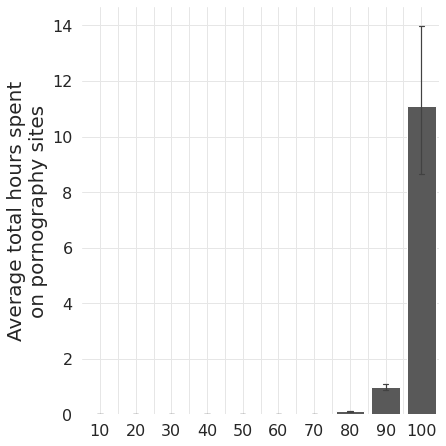

In [27]:
# (fold cell) Plot deciles
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

sns.barplot(
    x=f"decile_{outcome_var}",
    y=outcome_var,
    data=_df,
    color=".35",
    errorbar=("ci", 95),
    n_boot=10_000,
    errwidth=1.2,
    capsize=0.15,
)
# ax.set_yticks(range(0,50,10))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.set_xlabel("")
ax.set_ylabel("Average total hours spent\non pornography sites", size=20)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(os.path.join(FIGSAVEDIR, "distribution_duration_on_adultsites_fullsample"))

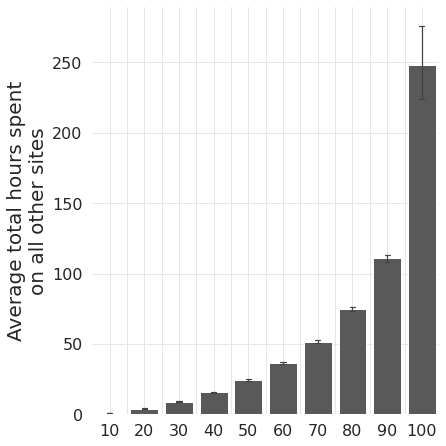

In [28]:
# (fold cell) Plot deciles
scale = 0.7
fig, ax = plt.subplots(figsize=(9 * scale, 9 * scale))

sns.barplot(
    x=f"decile_{outcome_var_c}",
    y=outcome_var_c,
    data=_df,
    color=".35",
    errorbar=("ci", 95),
    n_boot=10_000,
    errwidth=1.2,
    capsize=0.15,
)
# ax.set_yticks(range(0,50,10))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)
ax.set_xlabel("")
ax.set_ylabel("Average total hours spent\non all other sites", size=20)
ax.tick_params(axis="both", which="major", labelsize=16)
plt.tight_layout()
ax.xaxis.grid(True)
ax.get_xaxis().set_minor_locator(ticker.AutoMinorLocator(2))
ax.xaxis.grid(True, which="both", color=".9")
ax.yaxis.grid(True, which="both", color=".9")

sns.despine(left=True, bottom=True)
save_mpl_fig(
    os.path.join(FIGSAVEDIR, "distribution_duration_on_nonadultsites_fullsample")
)